In [31]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from additional_functions import *

# 
pollutans=["co","no2","so2","o3","pm2_5"]
aqi_levels={"pm2_5":[0,10,20,25,50,75],"no2":[0,40,90,120,230,340],"o3":[0,50,100,130,240,380],"so2":[0,100,200,350,500,750]}

In [126]:
'HDF ist ein deutlich besseres Format als csv/txt/... -> Dateitypen + Index bleibt erhalten '
pollution = pd.read_hdf("Pollution_Data/pollutant_data.h5")
predictor = pd.read_hdf("Predictor_Data/all.h5")
pollution.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3924 entries, 2010-01-01 to 2022-09-30
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   mean_co        3914 non-null   float64 
 1   max_value_co   3914 non-null   float64 
 2   max_hour_co    3914 non-null   float64 
 3   mean_so2       3566 non-null   float64 
 4   max_value_so2  3566 non-null   float64 
 5   max_hour_so2   3566 non-null   float64 
 6   mean_no2       3630 non-null   float64 
 7   max_value_no2  3630 non-null   float64 
 8   max_hour_no2   3630 non-null   float64 
 9   mean_o3        3777 non-null   float64 
 10  max_value_o3   3777 non-null   float64 
 11  max_hour_o3    3777 non-null   float64 
 12  mean_pm2_5     3414 non-null   float64 
 13  aqi_pm2_5      3414 non-null   category
 14  aqi_so2        3566 non-null   category
 15  aqi_no2        3630 non-null   category
 16  aqi_o3         3777 non-null   category
 17  aqi_idxmax     

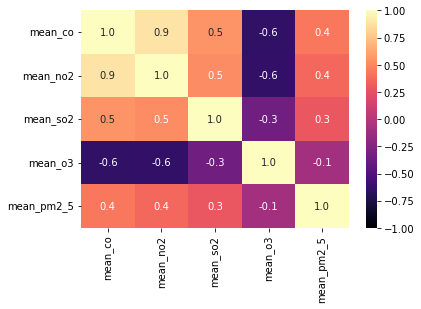

In [4]:
corr_mean_fig, corr_mean_ax = plt.subplots()
pollution_mean_corr=pollution[[f"mean_{i}" for i in pollutans]].corr()
corr_mean_ax = sns.heatmap(pollution_mean_corr,cmap="magma",vmin=-1,vmax=1,annot=True,fmt=".1f" )
corr_mean_fig.savefig("Visualization/EDA/Correlation_Heatmap_Mean_pollutans.png",dpi=200,bbox_inches="tight")

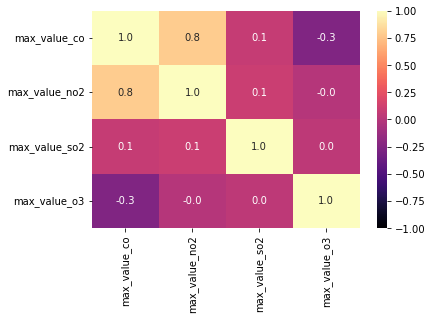

In [5]:
corr_max_fig, corr_max_ax = plt.subplots()
pollution_max_corr=pollution[[f"max_value_{i}" for i in pollutans[:4]]].corr()
sns.heatmap(pollution_max_corr,cmap="magma",vmin=-1,vmax=1,annot=True,fmt=".1f" )
corr_max_fig.savefig("Visualization/EDA/Correlation_Heatmap_Max_pollutans.png",dpi=200,bbox_inches="tight")

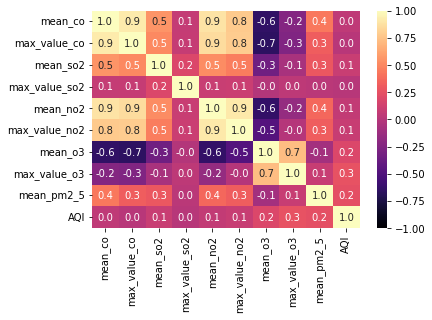

In [6]:
corr_fig, corr_ax = plt.subplots()
pollution_corr=pollution.drop([f"max_hour_{i}" for i in pollutans[:4]],axis=1).corr()
sns.heatmap(pollution_corr,cmap="magma",vmin=-1,vmax=1,annot=True,fmt=".1f")
corr_fig.savefig("Visualization/EDA/Correlation_Heatmap_pollutans.png",dpi=200,bbox_inches="tight")

## Korrelation zwischen den Schadstoffen

### Mittlere Tageswerte

Starke Korrellation: zwischen NO2 und CO
maßige Korr.: zw. SO2 und CO/NO2, PM2.5 und CO/NO2/SO2
keine/geringe Korr.: Ozon und PM2.5/SO2
negative Korr.: O3 und CO/NO2

### Zwischen den mean und max Werten: 

Starke Korrelation bedeuten, lange Lebensdauer oder der Grund für den Schadstoff "dauert lange"
- CO 0.9
- NO2 0.9
- O3 0.7

Gering: SO2 0.2

### Zwischen den maximal Werten: 

Nur zwischen NO2 und CO, der Rest nur geringe Korrelation


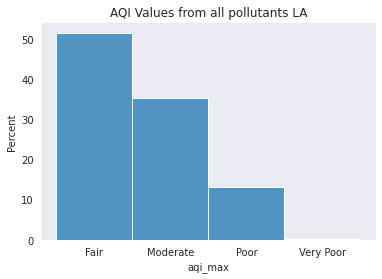

In [124]:
aqi_fig, aqi_ax = plt.subplots()
sns.histplot(x=pollution["aqi_max"],stat="percent").set(title="AQI Values from all pollutants LA")
aqi_fig.savefig("Visualization/EDA/AQI.png",dpi=200,bbox_inches="tight")

<AxesSubplot:title={'center':'Histogra_max_value_no2'}, xlabel='max_value_no2', ylabel='Percent'>

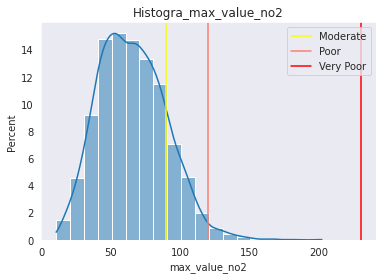

In [19]:
def pollutant_hist(pollutant,bins=5,max_value=True,show_aqi="all"):
    global aqi_levels
    sns.set_style("dark")
    if max_value:
        colname=f"max_value_{pollutant}"
    else:
        colname=f"mean_{pollutant}"
    fig=sns.histplot(pollution[colname],stat="percent",binwidth=bins,kde=True)
    fig.axvline(aqi_levels[pollutant][2],color="yellow",label="Moderate")
    if show_aqi=="all":
        fig.axvline(aqi_levels[pollutant][3],color="salmon",label="Poor")
        fig.axvline(aqi_levels[pollutant][4],color="red",label="Very Poor")
    fig.set_title(f"Histogra_{colname}")
    fig.legend()
    return fig

pollutant_hist("no2",bins=10)



In [121]:
sns.histplot(x=pollution["aqi_no2"],stat="percent")

KeyError: 'day'

<AxesSubplot:title={'center':'Histogra_mean_pm2_5'}, xlabel='mean_pm2_5', ylabel='Percent'>

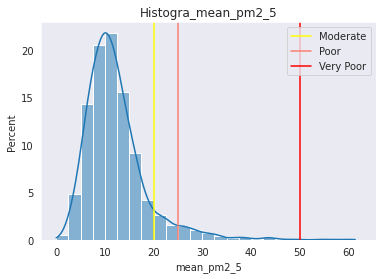

In [64]:
pollutant_hist("pm2_5",bins=2.5,max_value=False)

<AxesSubplot:xlabel='aqi_pm2_5', ylabel='Percent'>

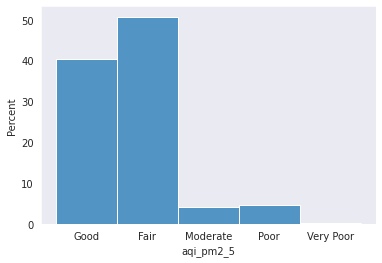

In [23]:
sns.histplot(x=pollution["aqi_pm2_5"],stat="percent")

<AxesSubplot:title={'center':'Histogra_max_value_so2'}, xlabel='max_value_so2', ylabel='Percent'>

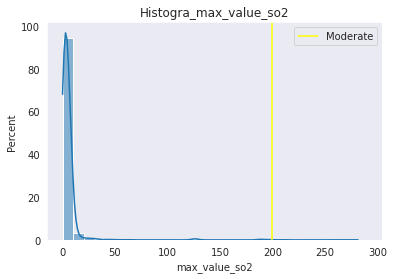

In [61]:
pollutant_hist("so2",bins=10,show_aqi="moderate")

<AxesSubplot:title={'center':'Histogra_max_value_o3'}, xlabel='max_value_o3', ylabel='Percent'>

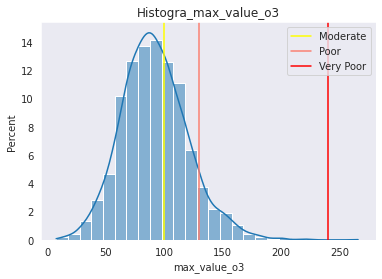

In [63]:
pollutant_hist("o3",bins=10,show_aqi="all")

<AxesSubplot:xlabel='aqi_o3', ylabel='Percent'>

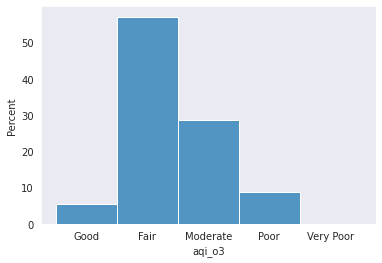

In [24]:
sns.histplot(x=pollution["aqi_o3"],stat="percent")

Damit wird deutlich, welche der Schadstoffe in LA hauptsächlich zur Luftverschmutzung beitragen:
- **O3** mit fast 50 % Moderat und schlechter
- PM 2.5 
- NO2 mit fast 25 % Moderat und schlechter (hier nur mean Wert, da kein max verfügbar)

SO2 ist dagegen nicht relevant. Das könnte daran liegen das der Standort in Downtown LA liegt und daher wenig Industrie benachbart ist und mittlerweile überall SO2 Filter-Systeme vorhanden sind.

**Die weiter Analyse wird sich deshalb hauptsächlich mit den drei Schadstoffen beschäftigen.**

count    3630.000000
mean       11.889532
std         7.637933
min         0.000000
25%         6.000000
50%         9.000000
75%        20.000000
max        23.000000
Name: max_hour_no2, dtype: float64

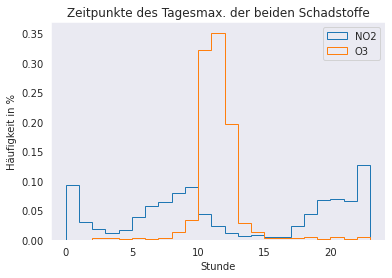

In [56]:
hour_fig, hour_ax = plt.subplots(1,1)

hour_ax.hist(pollution["max_hour_no2"],bins=range(0,24),histtype="step",density=True,label="NO2")
hour_ax.hist(pollution["max_hour_o3"],bins=range(0,24),histtype="step",density=True,label="O3")
hour_ax.set_title("Zeitpunkte des Tagesmax. der beiden Schadstoffe")
hour_ax.set_xlabel("Stunde")
hour_ax.set_ylabel("Häufigkeit in %")

hour_ax.legend()


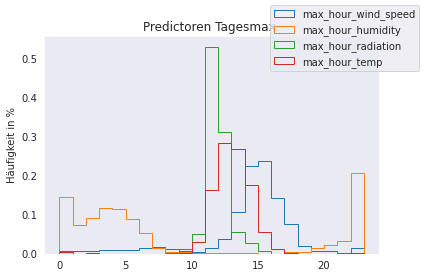

In [60]:
pred_hour_fig, pred_hour_ax = plt.subplots(1,1)
hour_columns=["max_hour_wind_speed","max_hour_humidity","max_hour_radiation","max_hour_temp"]
for column in hour_columns:
    pred_hour_ax.hist(predictor[column],bins=range(0,24),histtype="step",density=True,label=column)

pred_hour_ax.set_title("Predictoren Tagesmax.")
pred_hour_ax.set_ylabel("Stunden")
pred_hour_ax.set_ylabel("Häufigkeit in %")

pred_hour_fig.legend()

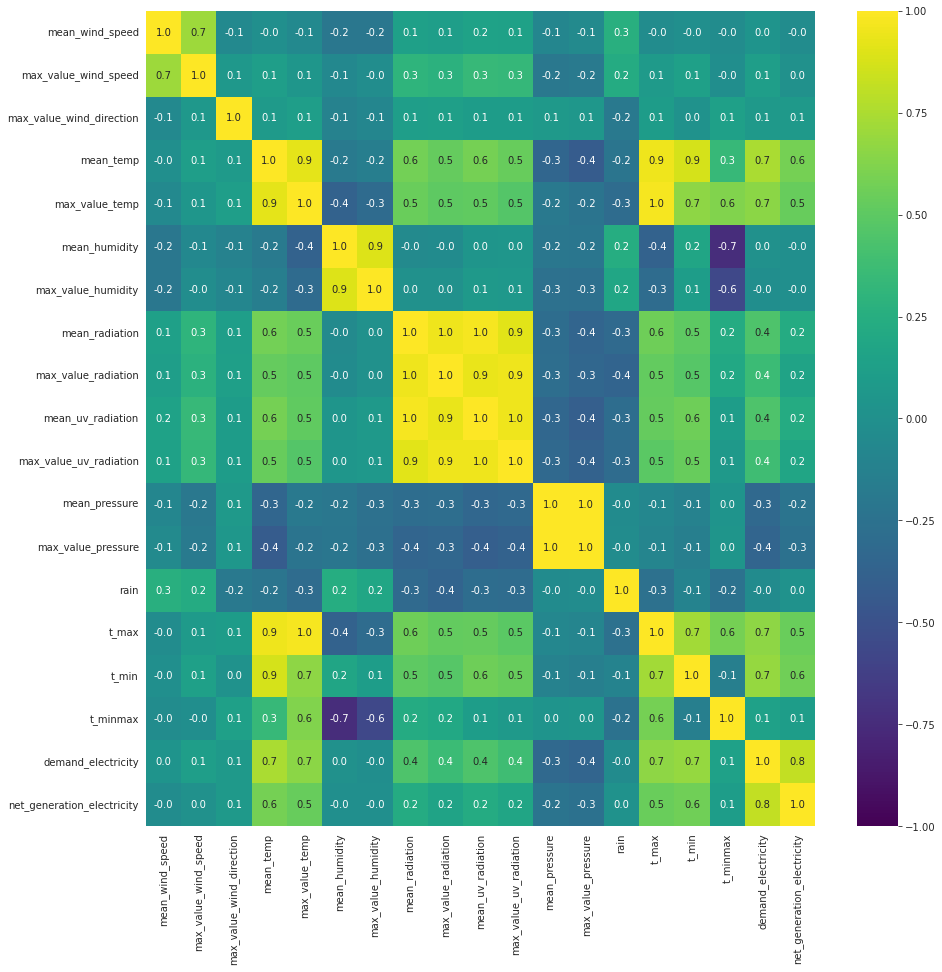

In [115]:
' ! Entfernen aller nicht Intervall/Ratioskalierten Werte d.h. z.B: Monat oder Windrichtung'
'Zählt dazu auch die Spalten mit max_hour_temp ???'
corr_fig, corr_ax = plt.subplots(figsize=(15,15))
predictor_corr=predictor.drop( ['day_of_week',
       'month', 'quarter', 'year',"mean_wind_direction",
       "max_hour_wind_speed","max_hour_wind_direction","max_hour_humidity","max_hour_radiation","max_hour_uv_radiation","max_hour_radiation",
       "max_hour_pressure","max_hour_temp"],axis=1).corr()
sns.heatmap(predictor_corr,cmap="viridis",vmin=-1,vmax=1,annot=True,fmt=".1f")
corr_fig.savefig("Visualization/EDA/Correlation_Heatmap_predictor.png",dpi=200,bbox_inches="tight")

## Resultate aus der Correlation Heatmap
- unspannend: Korrelation zwischen den mean und max Werten der jeweiligen Features
- hohe Temperaturen verursachen einen hohen Stromverbrauch --> Klimaanlagen
- hohe Temperaturdifferenzen an einem Tag (t_min_max) sorgen für hohe Luftfeuchtigkeit -> abgekühlte Luft kann nicht so viel Feuchtigkeit aufnehmen

In [118]:
predictor.columns

Index(['mean_wind_speed', 'max_value_wind_speed', 'max_hour_wind_speed',
       'mean_wind_direction', 'max_value_wind_direction',
       'max_hour_wind_direction', 'mean_temp', 'max_value_temp',
       'max_hour_temp', 'mean_humidity', 'max_value_humidity',
       'max_hour_humidity', 'mean_radiation', 'max_value_radiation',
       'max_hour_radiation', 'mean_uv_radiation', 'max_value_uv_radiation',
       'max_hour_uv_radiation', 'mean_pressure', 'max_value_pressure',
       'max_hour_pressure', 'rain', 't_max', 't_min', 't_minmax',
       'demand_electricity', 'net_generation_electricity', 'day_of_week',
       'month', 'quarter', 'year'],
      dtype='object')

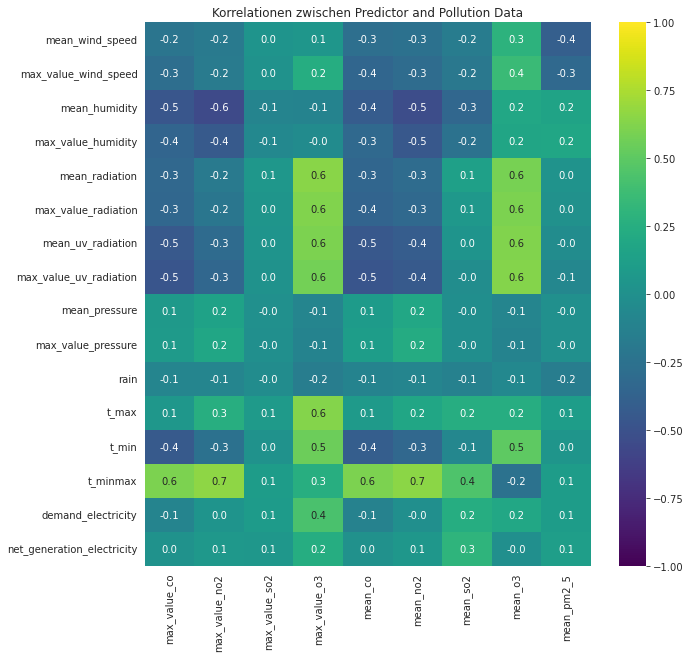

In [120]:
'Correlation zwischen den Schadstoffen und den Predictoren'
columns_poll=[f"max_value_{i}" for i in pollutans[:4]] + [f"mean_{i}" for i in pollutans]
predictor_columns=['mean_wind_speed','max_value_wind_speed','mean_humidity', 'max_value_humidity',
        'mean_radiation', 'max_value_radiation',
        'mean_uv_radiation', 'max_value_uv_radiation',
        'mean_pressure', 'max_value_pressure',
        'rain', 't_max', 't_min', 't_minmax',
       'demand_electricity', 'net_generation_electricity']
mixed_corr = pd.concat([pollution[columns_poll],predictor[predictor_columns]],axis=1)
#only the correlation between predictor and pollutants
mixed_corr = mixed_corr.corr().iloc[9::,0:9]

mixed_corr_fig, mixed_corr_ax = plt.subplots(figsize=(10,10))
sns.heatmap(mixed_corr,cmap="viridis",vmin=-1,vmax=1,annot=True,fmt=".1f").set(title="Korrelationen zwischen Predictor and Pollution Data")
mixed_corr_fig.savefig("Visualization/EDA/Correlation_Heatmap_mixed.png",dpi=200,bbox_inches="tight")

- Für die pm2_5 und SO2 zeigen sich nur geinge Korrelationen zwischen den Wetterdaten
  - negative Korrelation der Luftfeuchte und mean SO2 -> bildet sauren Regen, wieso dann aber nicht mit rain
- CO und NO2 zeigen beide ähnliches Verhalten (mean + max)
  - hohe Strahlung + Luftfeuchtigkeit führt zum Zerfall  
  - Temperaturunterschiede begünstigen hohe Werte -> geringer Zerfall bei niedriger Temp. ?
- O3 entsteht über radikalische Mechanismen
  - Strahlung und hohe Temp. begünstigen radik. Reaktionen


In [140]:
'PCA der predictor'
#Skalieren
scaler=StandardScaler()
predictor_scaled=pd.DataFrame(scaler.fit_transform(predictor[predictor_columns]),index=predictor.index,columns=predictor_columns)
predictor_scaled.dropna(axis=0,inplace=True)

#PCA
pca=PCA()
pca.fit(predictor_scaled)

PCA()

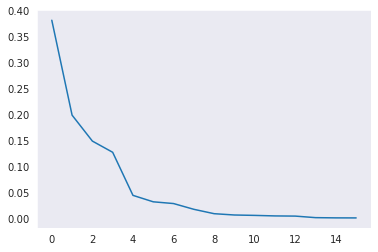

In [145]:
plt.plot(pca.explained_variance_ratio_)